<h1 style="text-align: center; font-weight: bold;">
Experiments Model LSTM 
</h1>


# LLibreries

In [169]:
# 📦 Gestió bàsica de dades i formats
import os
import json
import random
import warnings
from datetime import datetime
from itertools import combinations

# 📊 Tractament i visualització de dades
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import plotly.express as px

# Configuració visuals
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings("ignore")  # Ignorar warnings per evitar soroll

# 📈 Barra de progrés
from tqdm.notebook import tqdm

# 🧪 Preprocessament i mètriques
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error)

# 🤖 TensorFlow i Keras — Xarxes LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, LSTM
from keras import Model


# Funcions pròpies
import importlib
import lstm_functions
importlib.reload(lstm_functions)
from lstm_functions import *



# Importació Dades

Dades Carregades des del fitxer CSV netejat i guardat pel fitxer de data preprocessing

In [162]:
#Directori de treball

# Ruta on esta el script actual
__path__ = os.getcwd() # Si es fitxer .ipynb
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py

# Carpeta on es troben les dades
carpeta_dades = '../0_Data/Dades_T_estacions_xema_Z1'

# Fitxers de dades
fitxer_dades_csv = 'SCM_T_Z1.csv' # Nom del fitxer CSV amb totes les dades
fitxer_dades_csv_2009_2019 = 'SCM_T_Z1_2009_2019.csv' # Nom del fitxer CSV amb les dades de 2009 a 2019
fitxer_dades_csv_2020_2024 = 'SCM_T_Z1_2020_2024.csv' # Nom del fitxer CSV amb les dades de 2020 a 2024 (final dades)

# Path complet al fitxer CSV
path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades_csv)
path_dades_2009_2019 = os.path.join(__path__, carpeta_dades, fitxer_dades_csv_2009_2019)
path_dades_2020_2024 = os.path.join(__path__, carpeta_dades, fitxer_dades_csv_2020_2024)


# Importar les dades 2020_2024 per LSTM ja que son recents i no tenen interrupcions ni valors nuls

df_lstm = pd.read_csv(path_dades_2020_2024)

# Convertir la columna 'data' a tipus datetime
df_lstm['data'] = pd.to_datetime(df_lstm['data'], utc=True)

# Comprovar si hi ha valors nuls
print("Valors nuls per columna en dades LSTM:")
print(df_lstm.isnull().sum())

# Mostrar el df

df_lstm


Valors nuls per columna en dades LSTM:
data     0
valor    0
dtype: int64


,data,valor
0,2020-01-01 00:00:00+00:00,1.30
1,2020-01-01 01:00:00+00:00,1.60
2,2020-01-01 02:00:00+00:00,3.20
3,2020-01-01 03:00:00+00:00,4.40
4,2020-01-01 04:00:00+00:00,4.00
...,...,...
43843,2024-12-31 19:00:00+00:00,0.10
43844,2024-12-31 20:00:00+00:00,-0.60
43845,2024-12-31 21:00:00+00:00,-0.60
43846,2024-12-31 22:00:00+00:00,-0.70


### Visualització Prèvia de les dades

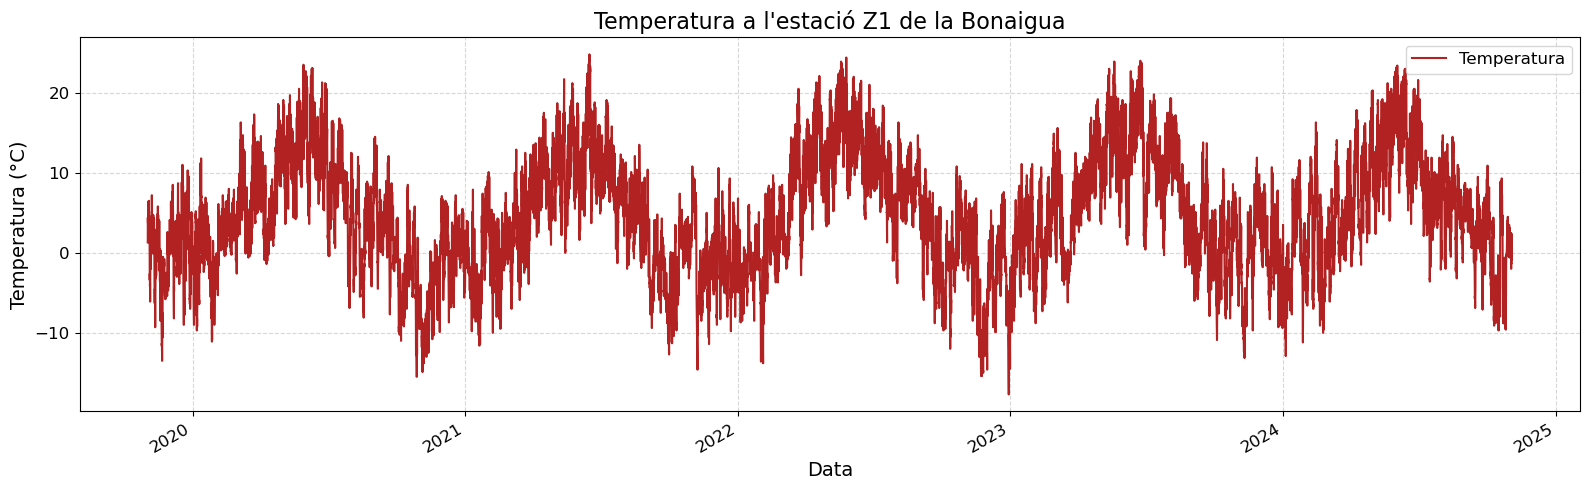

In [117]:
plt.figure(figsize=(16, 5))
plt.plot(df_lstm['data'], df_lstm['valor'], label='Temperatura', color='firebrick', linewidth=1.5)

# Millores visuals
plt.title('Temperatura a l\'estació Z1 de la Bonaigua', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Format de dates a l’eix X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Experimentació amb Varies configuracions LSTM usant Pipeline  

| ID | `window_size` | `n_outputs` | `n_layers` | `n_units` | `dropout` | Estratègies de predicció |
| -- | ------------- | ----------- | ---------- | --------- | --------- | ------------------------ |
| 0  | 24            | 1           | 1          | 1         | 0.2       | batch, iter, reinject    |
| 1  | 24            | 1           | 1          | 32        | 0.2       | batch, iter, reinject    |
| 2  | 48            | 1           | 2          | 64        | 0.2       | batch, iter, reinject    |
| 3  | 72            | 1           | 3          | 128       | 0.2       | batch, iter, reinject    |
| 4  | 48            | 6           | 2          | 64        | 0.2       | batch                    |
| 5  | 96            | 12          | 3          | 128       | 0.2       | batch                    |


In [ ]:
# Parametres Globals del model LSTM

# Parametres influents del model LSTM (Cal fer proves)

WINDOW_SIZE = [24, 48, 72, 96]   # Nombre de mostres per finestra temporal
N_OUTPUTS = [1, 6, 12]            # Nombre de mostres a predir (1h, 6h, 12h) (multioutput o unioutput)
N_LAYERS = [1, 2, 3]              # Nombre de capes LSTM
N_UNITS = [32, 64, 128]           # Nombre de neurones per capa LSTM


# Parametres menys influents del model LSTM (no cal tocar-los gaire)

N_FEATURES = 1                    # Nombre de característiques d'entrada (temperatura
N_SLIDE = N_OUTPUTS               # Desplaçament de la finestra temporal (per defecte igual a N_OUTPUTS)
BATCH_SIZE = 128                  # Mida del lot batch per l'entrenament
DROPOUT = [0.0, 0.1, 0.2]        # Taxa de dropout per evitar sobreajustament
EPOCHS = 50                       # Nombre d'èpoques per l'entrenament
PATIENCE = 5                      # Paciencia per l'early stopping
PREDICTIONS_MOD = [               # Tipus de predicció a realitzar
            'pred_batch',
            'pred_iter',
            'pred_reinject'
            ]        


In [ ]:
# Directoris dels experiments per guardar els models i resultats

#Carpeta resultats experiments (save_path per la pipeline)
carpeta_resultats = 'models_results_experiments'

## Experiment 0: LSTM with 1 Layer and 1 Unit (BASE)

In [10]:
# Nom de la carpeta per l'experiment
carpeta_experiment = 'experiment_0'
path_experiment = os.path.join(__path__, carpeta_resultats, carpeta_experiment) # Path complet a la carpeta de l'experiment


# Parametres influents del model LSTM (Experiment base minimalista)

WINDOW_SIZE = 24                # Nombre de mostres per finestra (24 hores)
N_OUTPUTS = 1                   # Predicció d'1 hora vista
N_LAYERS = 1                    # Només una capa LSTM
N_UNITS = 1                     # Una sola neurona
DROPOUT_RATE = 0.2              # Dropout per estabilitzar (tot i ser petit)

# Parametres menys influents (es deixen fixos)

BATCH_SIZE = 128                # Batch gran per estabilitat
EPOCHS = 50                     # Entrenament complet
PATIENCE = 5                    # EarlyStopping
N_SLIDE = N_OUTPUTS             # Per predicció puntual
N_FEATURES = 1                  # Una sola variable (temperatura)
PREDICTIONS_MOD = [
    'pred_batch',
    'pred_iter',
    'pred_reinject'
]

🧠 [1/5] Entrenant el model LSTM...
✅ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0629 - val_loss: 0.0122
Epoch 2/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0192 - val_loss: 0.0066
Epoch 3/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - val_loss: 0.0049
Epoch 4/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - val_loss: 0.0046
Epoch 5/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0048
Epoch 6/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0079 - val_loss: 0.0053
Epoch 7/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_loss: 0.0058
Epoch 8/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0075 - val_loss: 0.0062
Epoch 9/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0076 - val_loss: 0.0066

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44 (180.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30 (124.00 B)

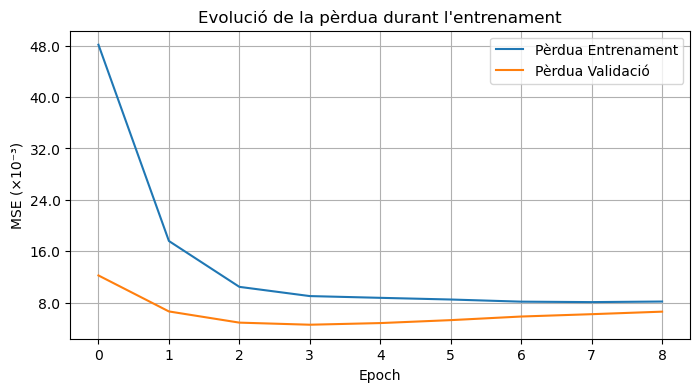

Entrenament completat.
💾 [2/5] Guardant model i gràfica de pèrdua...
🔮 [3/5] Fent prediccions...
Fent predicció batch...
Fent predicció iterativa...
Fent predicció iterativa amb reinjecció...
📊 [4/5] Generant gràfic de prediccions...


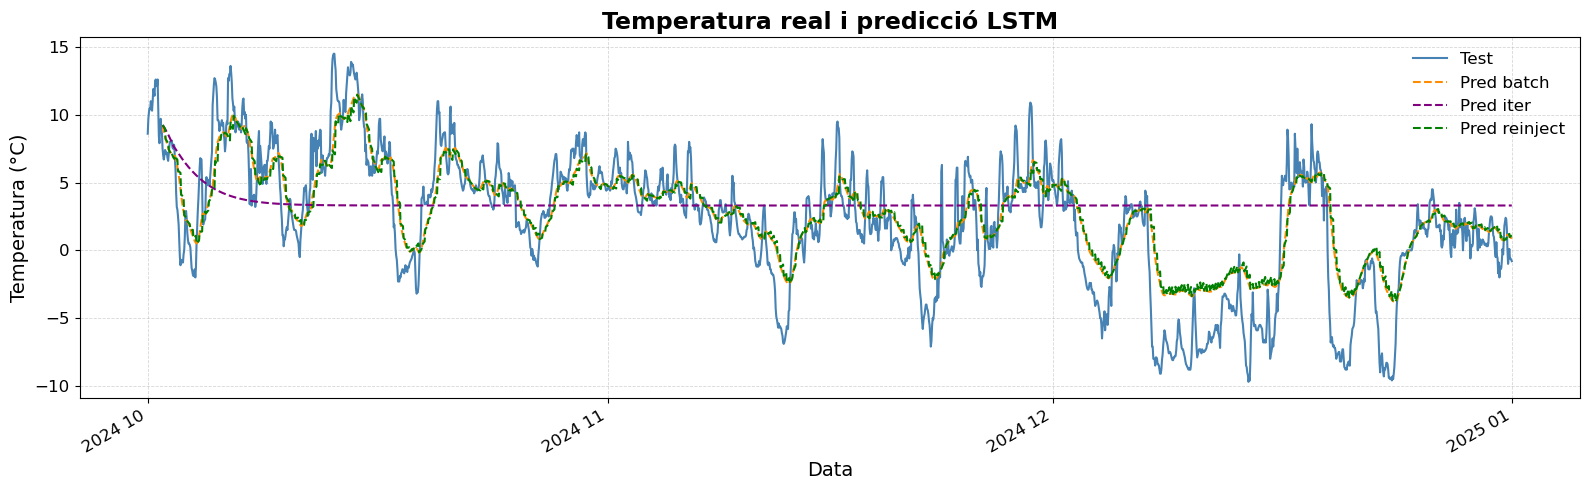

🗃️ [5/5] Guardant prediccions, mètriques i configuració...


In [ ]:

model, scaler, df_train, df_val, df_test_pred, history, metriques, fig, fig_loss_train = pipeline_lstm(
    df_lstm=df_lstm,
    window_size=WINDOW_SIZE,     
    n_outputs=N_OUTPUTS,
    n_layers=N_LAYERS,
    n_units=N_UNITS,        
    dropout_rate=DROPOUT_RATE,
    optimizer='adam',
    loss='mse',
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    patience=PATIENCE,
    shuffle=False,
    seed=42,
    dies_train=0,
    mostrar_val=False,
    col_preds=PREDICTIONS_MOD,
    save_path=path_experiment,
    show=True,
    summary=True
)


## Experiments 1-5: LSTM with Varying Parameters

In [ ]:

EXPERIMENTS = [1, 2, 3, 4, 5] # Llista d'experiments a realitzar (per iterar sobre els paràmetres)

# Llistes de paràmetres per experiments definits manualment

WINDOW_SIZES =    [24, 24, 48, 72, 48, 96]
N_OUTPUTS_LIST =  [ 1,  1,  1,  1,  6, 12]
N_LAYERS_LIST =   [ 1,  1,  2,  3,  2,  3]
N_UNITS_LIST =    [ 1, 32, 64,128, 64,128]


DROPOUT_RATE = 0.2
BATCH_SIZE = 128                # Batch gran per estabilitat
EPOCHS = 50                     # Entrenament complet
PATIENCE = 5                    # EarlyStopping
N_SLIDE = N_OUTPUTS                     # Per predicció puntual (igual a N_OUTPUTS)
N_FEATURES = 1                  # Una sola variable (temperatura)
PREDICTIONS_MOD = [
    'pred_batch',
    'pred_iter',
    'pred_reinject'
]



In [17]:
for i in EXPERIMENTS:
    
    print(f"\n🚀 Executant experiment {i}...")

    # Agafar paràmetres per aquest experiment
    window_size = WINDOW_SIZES[i]
    n_outputs = N_OUTPUTS_LIST[i]
    n_layers = N_LAYERS_LIST[i]
    n_units = N_UNITS_LIST[i]

    # Nom de la carpeta per a l'experiment
    carpeta_exp = f"experiment_{i}"
    path_experiment = os.path.join(__path__, carpeta_resultats, carpeta_exp)
    os.makedirs(path_experiment, exist_ok=True)

    
    # Executar pipeline
    model, scaler, df_train, df_val, df_test_pred, history, metriques, fig, fig_loss_train = pipeline_lstm(
        df_lstm=df_lstm,
        window_size=window_size,
        n_outputs=n_outputs,
        n_layers=n_layers,
        n_units=n_units,
        dropout_rate=DROPOUT_RATE,
        optimizer='adam',
        loss='mse',
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        patience=PATIENCE,
        shuffle=False,
        seed=42,
        dies_train=0,
        mostrar_val=False,
        col_preds= PREDICTIONS_MOD,
        save_path=path_experiment,
        show=True,
        summary=False
    )

    print(f"✅ Experiment {i} completat i guardat a: {path_experiment}")



🚀 Executant experiment 1...
🧠 [1/5] Entrenant el model LSTM...
✅ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0549 - val_loss: 0.0051
Epoch 2/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0064 - val_loss: 0.0036
Epoch 3/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 4/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 5/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 6/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 7/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 8/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0020 - val_loss: 9.4741e-04
Epoch 9/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0018 - val_loss: 7.7837e-04
Epoch 10/

Entrenament completat.
💾 [2/5] Guardant model i gràfica de pèrdua...
🔮 [3/5] Fent prediccions...
Fent predicció batch...
Fent predicció iterativa...
Fent predicció iterativa amb reinjecció...
📊 [4/5] Generant gràfic de prediccions...

📈 Mètriques calculades:
         pred_batch  pred_iter  pred_reinject
Mètrica                                      
RMSE           0.80      12.39           1.81
MSE            0.64     153.44           3.28
MAE            0.57      11.35           1.35
🗃️ [5/5] Guardant prediccions, mètriques i configuració...
✅ Experiment 1 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments/experiment_1

🚀 Executant experiment 2...
🧠 [1/5] Entrenant el model LSTM...
✅ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 0.0129 - val_loss

Entrenament completat.
💾 [2/5] Guardant model i gràfica de pèrdua...
🔮 [3/5] Fent prediccions...
Fent predicció batch...
Fent predicció iterativa...
Fent predicció iterativa amb reinjecció...
📊 [4/5] Generant gràfic de prediccions...

📈 Mètriques calculades:
         pred_batch  pred_iter  pred_reinject
Mètrica                                      
RMSE           0.77      11.56           1.61
MSE            0.60     133.59           2.60
MAE            0.53      10.40           1.13
🗃️ [5/5] Guardant prediccions, mètriques i configuració...
✅ Experiment 2 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments/experiment_2

🚀 Executant experiment 3...
🧠 [1/5] Entrenant el model LSTM...
✅ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 77s 243ms/step - loss: 0.0149 - val_los

Entrenament completat.
💾 [2/5] Guardant model i gràfica de pèrdua...
🔮 [3/5] Fent prediccions...
Fent predicció batch...
Fent predicció iterativa...
Fent predicció iterativa amb reinjecció...
📊 [4/5] Generant gràfic de prediccions...

📈 Mètriques calculades:
         pred_batch  pred_iter  pred_reinject
Mètrica                                      
RMSE           0.77      10.63           1.64
MSE            0.59     113.08           2.70
MAE            0.53       9.47           1.17
🗃️ [5/5] Guardant prediccions, mètriques i configuració...
✅ Experiment 3 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments/experiment_3

🚀 Executant experiment 4...
🧠 [1/5] Entrenant el model LSTM...
✅ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0846 - val_loss: 0

Entrenament completat.
💾 [2/5] Guardant model i gràfica de pèrdua...
🔮 [3/5] Fent prediccions...
Fent predicció batch multi-output...
📊 [4/5] Generant gràfic de prediccions...

📈 Mètriques calculades:
         pred_batch
Mètrica            
RMSE           1.65
MSE            2.71
MAE            1.18
🗃️ [5/5] Guardant prediccions, mètriques i configuració...
✅ Experiment 4 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments/experiment_4

🚀 Executant experiment 5...
🧠 [1/5] Entrenant el model LSTM...
✅ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 330ms/step - loss: 0.1099 - val_loss: 0.0193
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 295ms/step - loss: 0.0150 - val_loss: 0.0073
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 295ms/step - loss: 0.0114 - val_loss: 0.0077
Epoch 4/

Entrenament completat.
💾 [2/5] Guardant model i gràfica de pèrdua...
🔮 [3/5] Fent prediccions...
Fent predicció batch multi-output...
📊 [4/5] Generant gràfic de prediccions...

📈 Mètriques calculades:
         pred_batch
Mètrica            
RMSE           3.14
MSE            9.88
MAE            2.33
🗃️ [5/5] Guardant prediccions, mètriques i configuració...
✅ Experiment 5 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments/experiment_5


## Experiments 0-5: Variant paramentres amb Lookahead 6

| ID | `window_size` | `n_outputs` | `n_layers` | `n_units` | `dropout` | `lookahead` | Estratègies de predicció |
| -- | ------------- | ----------- | ---------- | --------- | --------- | ----------- | ------------------------ |
| 0  | 24            | 1           | 1          | 1         | 0.2       | 6           | batch, iter, reinject    |
| 1  | 24            | 1           | 1          | 32        | 0.2       | 6           | batch, iter, reinject    |
| 2  | 48            | 1           | 2          | 64        | 0.2       | 6           | batch, iter, reinject    |
| 3  | 72            | 1           | 3          | 128       | 0.2       | 6           | batch, iter, reinject    |
| 4  | 48            | 6           | 2          | 64        | 0.2       | 6           | batch                    |
| 5  | 96            | 12          | 3          | 128       | 0.2       | 6           | batch                    |



In [ ]:
# Directoris dels experiments per guardar els models i resultats

#Carpeta resultats experiments (save_path per la pipeline)
carpeta_resultats = 'models_results_experiments_lookahead'


EXPERIMENTS = [1, 2, 3, 4, 5] # Llista d'experiments a realitzar (per iterar sobre els paràmetres)

# Llistes de paràmetres per experiments definits manualment

WINDOW_SIZE =    [24, 24, 48, 72, 48, 96]
N_OUTPUTS =  [ 1,  1,  1,  1,  6, 12]
N_LAYERS =   [ 1,  1,  2,  3,  2,  3]
N_UNITS =    [ 1, 32, 64,128, 64,128]
LOOKAHEAD = 6

DROPOUT_RATE = 0.2
BATCH_SIZE = 128                # Batch gran per estabilitat
EPOCHS = 50                     # Entrenament complet
PATIENCE = 5                    # EarlyStopping
N_SLIDE = N_OUTPUTS             # Per predicció puntual (igual a N_OUTPUTS)
N_FEATURES = 1                  # Una sola variable (temperatura)
PREDICTIONS_MOD = [
    'pred_batch',
    'pred_reinject'
]




🚀 Executant experiment 1...
🧠 [1/5] Entrenant el model LSTM...
✅ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0234 - val_loss: 0.0074
Epoch 2/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0082 - val_loss: 0.0072
Epoch 3/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0076 - val_loss: 0.0071
Epoch 4/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 5/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 6/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 7/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 8/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 9/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 10/50
308/3

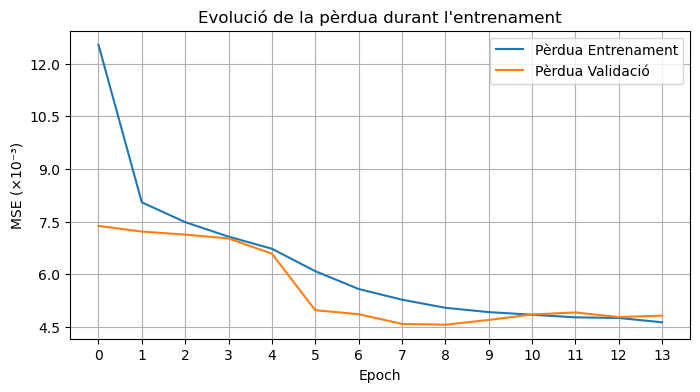

Entrenament completat.
💾 [2/5] Guardant model i gràfica de pèrdua...
🔮 [3/5] Fent prediccions...
Fent predicció batch...
Fent predicció iterativa...
Fent predicció iterativa amb reinjecció...
📊 [4/5] Generant gràfic de prediccions...


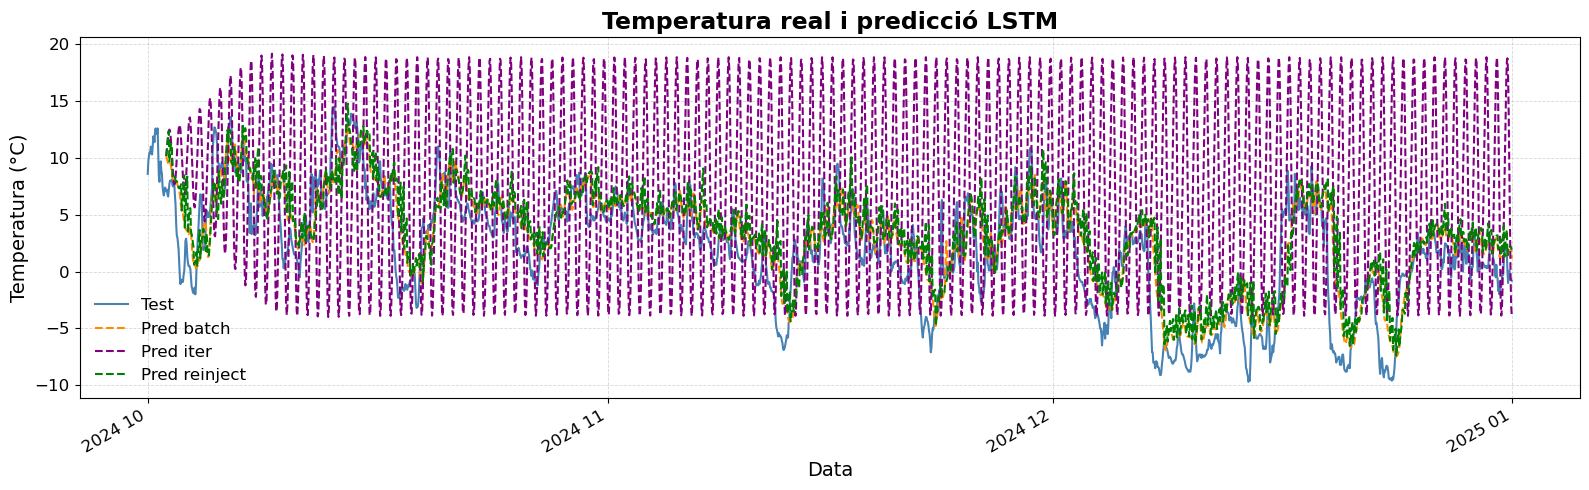


📈 Mètriques calculades:
         pred_batch  pred_iter  pred_reinject
Mètrica                                      
RMSE           2.74      10.66           3.39
MSE            7.51     113.59          11.52
MAE            2.11       8.73           2.59
🗃️ [5/5] Guardant prediccions, mètriques i configuració...
✅ Experiment 1 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments_lookahead/experiment_1

🚀 Executant experiment 2...
🧠 [1/5] Entrenant el model LSTM...
✅ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 0.0152 - val_loss: 0.0073
Epoch 2/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - loss: 0.0073 - val_loss: 0.0048
Epoch 3/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0061 - val_loss: 0.0040
Epoch 4/50
308/308 ━━━━━━━━━━━━━━━━━━━━

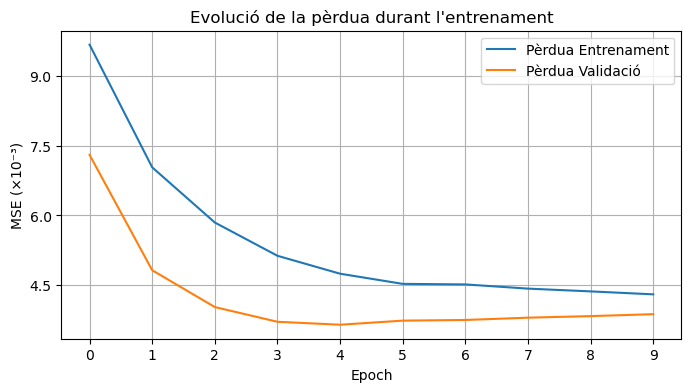

Entrenament completat.
💾 [2/5] Guardant model i gràfica de pèrdua...
🔮 [3/5] Fent prediccions...
Fent predicció batch...
Fent predicció iterativa...
Fent predicció iterativa amb reinjecció...
📊 [4/5] Generant gràfic de prediccions...


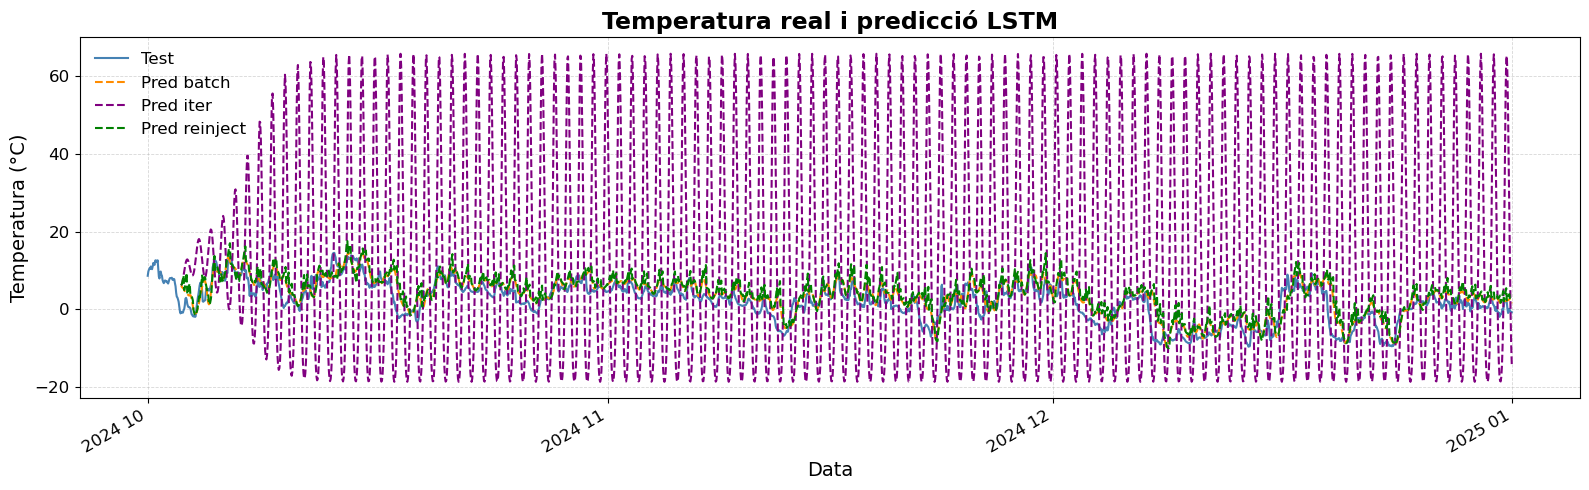


📈 Mètriques calculades:
         pred_batch  pred_iter  pred_reinject
Mètrica                                      
RMSE           2.89      32.41           3.67
MSE            8.34    1050.54          13.45
MAE            2.25      25.86           2.89
🗃️ [5/5] Guardant prediccions, mètriques i configuració...
✅ Experiment 2 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments_lookahead/experiment_2

🚀 Executant experiment 3...
🧠 [1/5] Entrenant el model LSTM...
✅ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 70s 220ms/step - loss: 0.0170 - val_loss: 0.0073
Epoch 2/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 66s 213ms/step - loss: 0.0077 - val_loss: 0.0053
Epoch 3/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 65s 211ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 4/50
308/308 ━━━━━━━━━━━━━━━━━

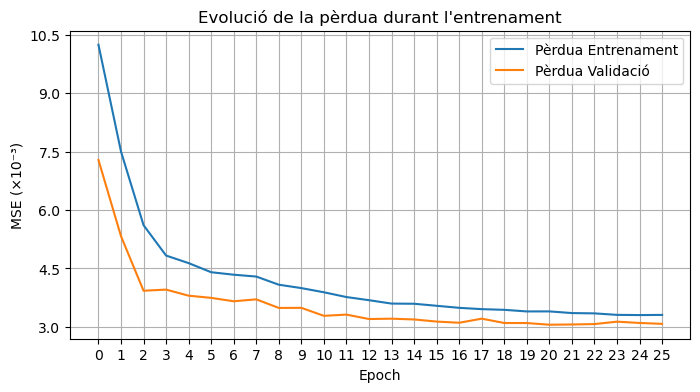

Entrenament completat.
💾 [2/5] Guardant model i gràfica de pèrdua...
🔮 [3/5] Fent prediccions...
Fent predicció batch...
Fent predicció iterativa...
Fent predicció iterativa amb reinjecció...
📊 [4/5] Generant gràfic de prediccions...


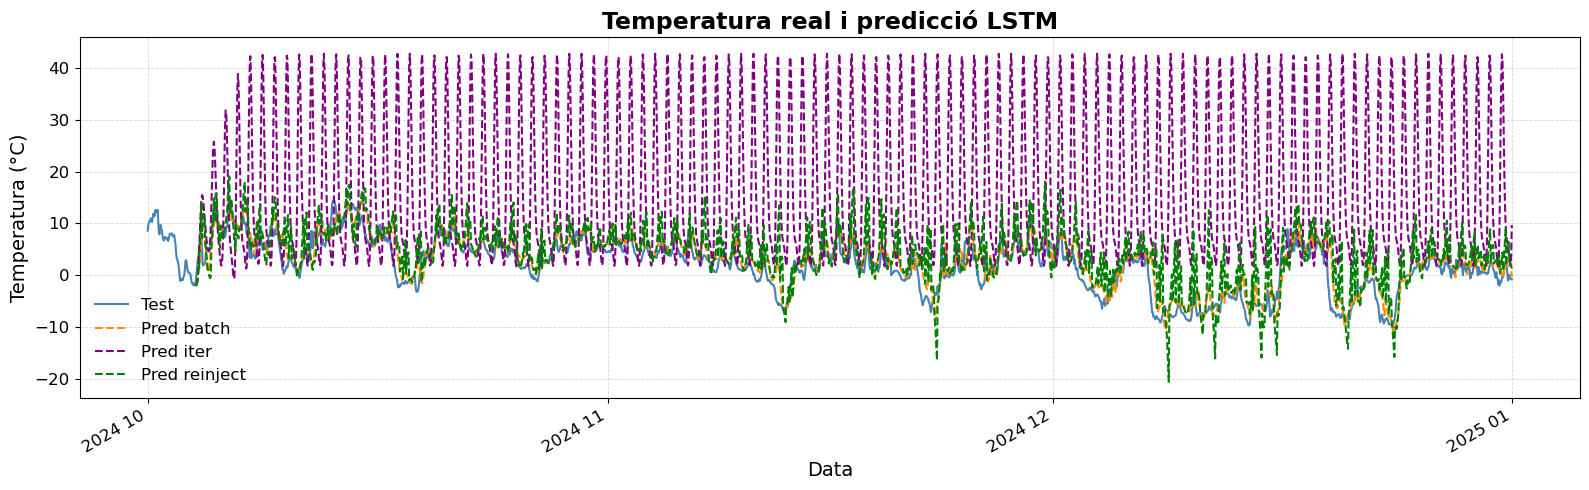


📈 Mètriques calculades:
         pred_batch  pred_iter  pred_reinject
Mètrica                                      
RMSE           2.38      20.34           4.49
MSE            5.69     413.83          20.14
MAE            1.82      15.04           3.38
🗃️ [5/5] Guardant prediccions, mètriques i configuració...
✅ Experiment 3 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments_lookahead/experiment_3

🚀 Executant experiment 4...
🧠 [1/5] Entrenant el model LSTM...
✅ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0852 - val_loss: 0.0132
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0135 - val_loss: 0.0087
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0119 - val_loss: 0.0116
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/st

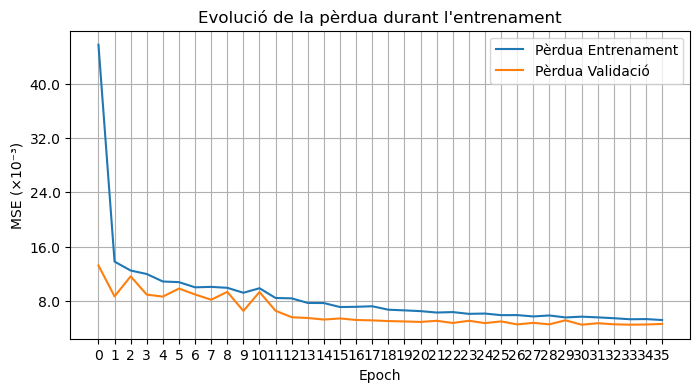

Entrenament completat.
💾 [2/5] Guardant model i gràfica de pèrdua...
🔮 [3/5] Fent prediccions...
Fent predicció batch multi-output...
⚠️ Avís: la columna 'pred_iter' no existeix a df_test_pred. Es descarta.
⚠️ Avís: la columna 'pred_reinject' no existeix a df_test_pred. Es descarta.
📊 [4/5] Generant gràfic de prediccions...


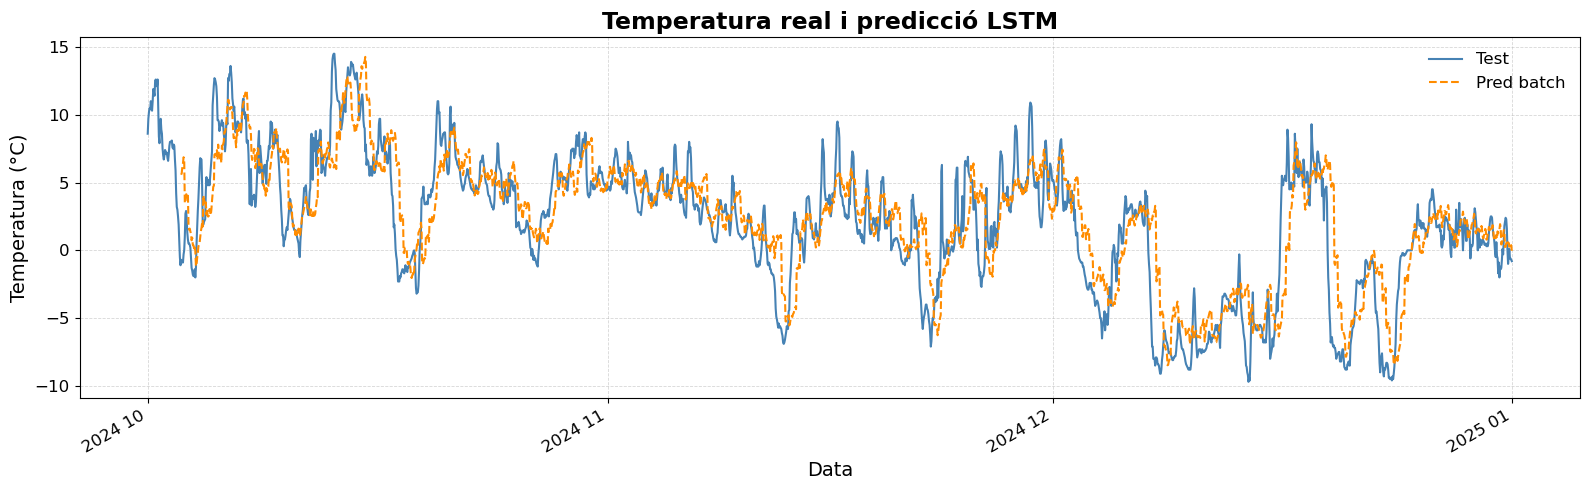


📈 Mètriques calculades:
         pred_batch
Mètrica            
RMSE           2.75
MSE            7.58
MAE            1.99
🗃️ [5/5] Guardant prediccions, mètriques i configuració...
✅ Experiment 4 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments_lookahead/experiment_4

🚀 Executant experiment 5...
🧠 [1/5] Entrenant el model LSTM...
✅ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 296ms/step - loss: 0.1101 - val_loss: 0.0200
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - loss: 0.0159 - val_loss: 0.0075
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - loss: 0.0121 - val_loss: 0.0077
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - loss: 0.0111 - val_loss: 0.0091
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - loss: 0.0106 - val_loss: 0.0102
Ep

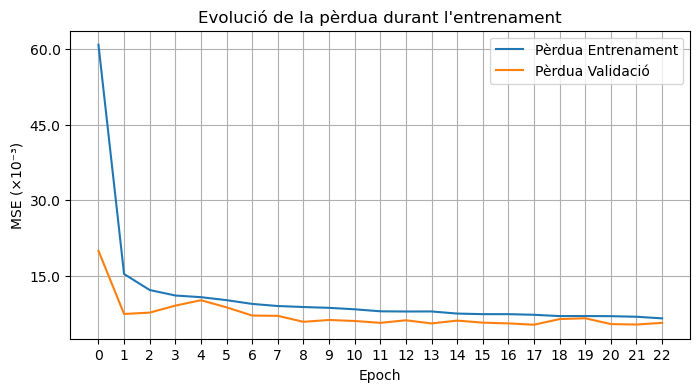

Entrenament completat.
💾 [2/5] Guardant model i gràfica de pèrdua...
🔮 [3/5] Fent prediccions...
Fent predicció batch multi-output...
⚠️ Avís: la columna 'pred_iter' no existeix a df_test_pred. Es descarta.
⚠️ Avís: la columna 'pred_reinject' no existeix a df_test_pred. Es descarta.
📊 [4/5] Generant gràfic de prediccions...


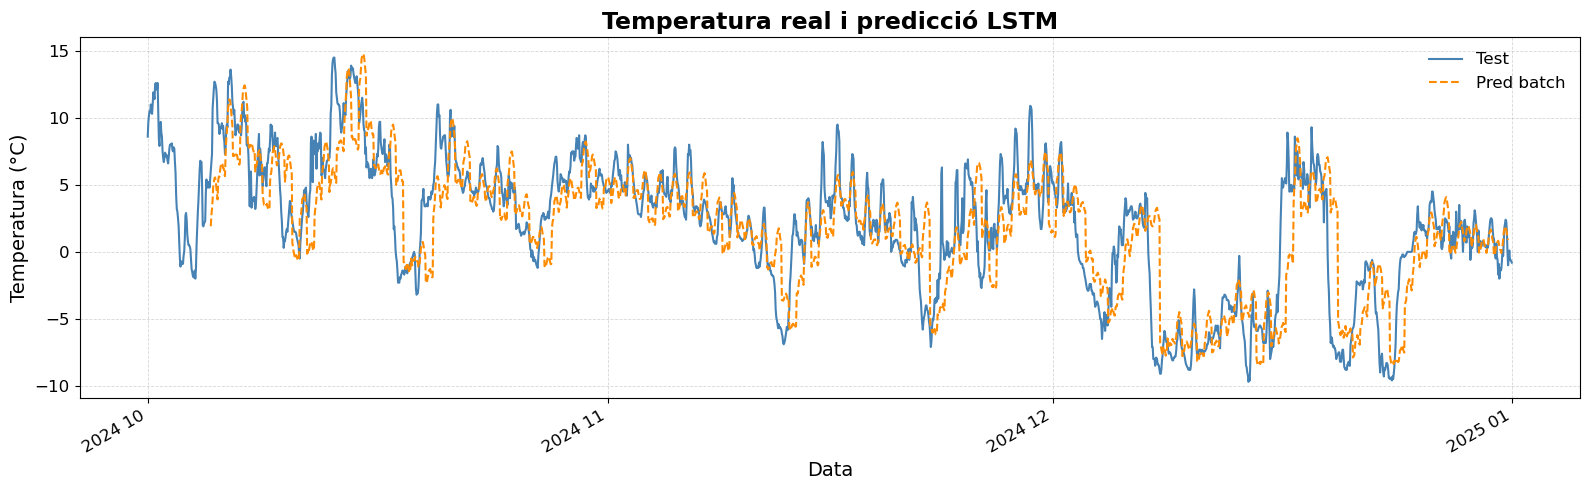


📈 Mètriques calculades:
         pred_batch
Mètrica            
RMSE           3.09
MSE            9.57
MAE            2.25
🗃️ [5/5] Guardant prediccions, mètriques i configuració...
✅ Experiment 5 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments_lookahead/experiment_5


In [ ]:
for i in EXPERIMENTS:
    
    print(f"\n🚀 Executant experiment {i}...")

    # Agafar paràmetres per aquest experiment
    window_size = WINDOW_SIZE[i]
    n_outputs = N_OUTPUTS[i]
    n_layers = N_LAYERS[i]
    n_units = N_UNITS[i]

    # Nom de la carpeta per a l'experiment
    carpeta_exp = f"experiment_{i}"
    path_experiment = os.path.join(__path__, carpeta_resultats, carpeta_exp)
    os.makedirs(path_experiment, exist_ok=True)

    
    # Executar pipeline
    model, scaler, df_train, df_val, df_test_pred, history, metriques, fig, fig_loss_train = pipeline_lstm(
        df_lstm=df_lstm,
        window_size=window_size,
        n_outputs=n_outputs,
        lookahead=LOOKAHEAD,
        n_layers=n_layers,
        n_units=n_units,
        dropout_rate=DROPOUT_RATE,
        optimizer='adam',
        loss='mse',
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        patience=PATIENCE,
        shuffle=False,
        seed=42,
        dies_train=0,
        mostrar_val=False,
        col_preds= PREDICTIONS_MOD,
        save_path=path_experiment,
        show=True,
        summary=False
    )

    print(f"✅ Experiment {i} completat i guardat a: {path_experiment}")


## Experiments amb lookahead 12

| ID | `window_size` | `n_outputs` | `n_layers` | `n_units` | `dropout` | `lookahead` | Estratègies de predicció      |
| -- | ------------- | ----------- | ---------- | --------- | --------- | ----------- | ----------------------------- |
| 0  | 24            | 1           | 1          | 1         | 0.2       | 12          | `pred_batch`, `pred_reinject` |
| 1  | 24            | 1           | 1          | 32        | 0.2       | 12          | `pred_batch`, `pred_reinject` |
| 2  | 48            | 1           | 2          | 64        | 0.2       | 12          | `pred_batch`, `pred_reinject` |
| 3  | 72            | 1           | 3          | 128       | 0.2       | 12          | `pred_batch`, `pred_reinject` |
| 4  | 48            | 6           | 2          | 64        | 0.2       | 12          | `pred_batch`, `pred_reinject` |
| 5  | 96            | 12          | 3          | 128       | 0.2       | 12          | `pred_batch`, `pred_reinject` |
